<a href="https://colab.research.google.com/github/RH00000/Rice_LLM_Replicability_Project/blob/main/prompt_3_for_gemini_2_5_pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q google-generativeai pandas openpyxl

In [ ]:
#import
from google import genai
import os
import requests
import pandas as pd
import re
import time
from google.colab import files, userdata
userdata.get('GEMINI_API_KEY')

In [3]:
#Initialize Gemini Client
client = genai.Client(api_key=userdata.get('GEMINI_API_KEY'))

In [4]:
#Upload and Load Excel File
uploaded = files.upload()
excel_file = list(uploaded.keys())[0]
df = pd.read_excel(excel_file, sheet_name=0).dropna(how="all")

Saving data_for_code.xlsx to data_for_code.xlsx


In [5]:
#Ensure prompt_3 column exists
if "prompt_3" not in df.columns:
    raise KeyError("Excel must have a 'prompt_3' column with full prompts.")
else:
  print("prompt exists")

prompt exists


In [6]:
#Helper to extract probability from first line
def extract_prob(text):
    first_line = text.strip().splitlines()[0]
    m = re.search(r"\b(0(?:\.\d+)?|1(?:\.0+)?)\b", first_line)
    return float(m.group(0)) if m else None

In [7]:
#Main Loop with Rate Limiting (build two lists instead of dicts)
probs   = []
outputs = []

#Resume support
autosave_file = 'autosave_file' # Define autosave_file
start_idx = 0
if os.path.exists(autosave_file):
    try:
        saved = pd.read_csv(autosave_file)
        # If you want to resume into the new scheme, you could load probs/outputs from saved
        # but for simplicity this example always starts fresh
        start_idx = len(saved)
        # Load existing results if resuming
        if start_idx > 0:
            probs = saved["replication_probability"].tolist()
            outputs = saved["model_output"].tolist()
    except Exception as e:
        print(f"Error loading autosave file: {e}. Starting fresh.")
        start_idx = 0
        probs = []
        outputs = []

if start_idx > 0:
    print(f"Resuming from row {start_idx}")


# Iterate over the DataFrame's index instead of a range
for idx in df.index[start_idx:]:
    prompt = df.at[idx, "prompt_3"]
    try:
        response = client.models.generate_content(
            model="gemini-2.5-pro",
            contents=[prompt]
        )
        text = response.candidates[0].content.parts[0].text.strip()
        prob = extract_prob(text)
    except Exception as e:
        text = f"Error: {e}"
        prob = None

    probs.append(prob)
    outputs.append(text)

    # Autosave the partial results
    # Use the actual index for saving
    if (len(probs)) % 10 == 0:
        # Get the corresponding part of the original DataFrame
        df_partial = df.iloc[:len(probs)].copy()
        df_partial["replication_probability"] = probs
        df_partial["model_output"]            = outputs
        df_partial.to_csv(autosave_file, index=False)
        print(f"Autosaved through row {len(probs)-1}")

    time.sleep(1.0)

# Attach to original df & save
df["replication_probability"] = probs
df["model_output"]            = outputs

# Write all original columns + the two new ones:
df.to_csv("predictions_output_final.csv", index=False)
files.download("predictions_output_final.csv")

Autosaved through row 9
Autosaved through row 19
Autosaved through row 29
Autosaved through row 39
Autosaved through row 49
Autosaved through row 59
Autosaved through row 69
Autosaved through row 79
Autosaved through row 89
Autosaved through row 99


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
!pip install -q scikit-learn

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve

In [10]:
df_result = pd.read_csv("predictions_output_final.csv")

In [16]:
#Drop rows where "replication_probability" is blank
df_clean = df_result.dropna(subset=["replication_probability"]).copy()

#Convert replication probability to float
df_clean["replication_probability"] = df_clean["replication_probability"].astype(float)

In [17]:
#Convert ground truth to binary labels
df_clean["replicated"] = df_clean["Result (replicated?)"].str.strip().str.lower().map({"yes": 1, "no": 0})

In [18]:
#Compute AUC
auc = roc_auc_score(df_clean["replicated"], df_clean["replication_probability"])
print(f"AUC: {auc:.4f}")

AUC: 0.6064


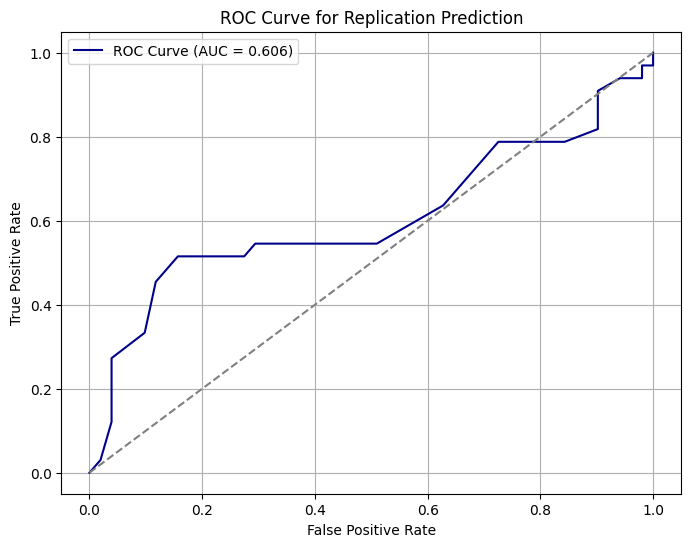

In [20]:
from matplotlib import pyplot as plt

# ROC curve
fpr, tpr, _ = roc_curve(df_clean["replicated"], df_clean["replication_probability"])

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.3f})", color="darkblue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Replication Prediction")
plt.legend()
plt.grid(True)
plt.show()

In [21]:
print(len(df_clean))

84
